# Extended solution
The notebook contains several examples of how you can use the extended solution.

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import font_manager
import textwrap
import math

font_dirs = ['/home/ys792/.fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.style.use('default')
plt.rcParams["font.family"] = "Raleway"

In [87]:
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable

    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    format_cfg: dict, defaults to None
        A dictionary with formatting configurations

    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=None):
        
        # Default formatting
        self.format_cfg = {
            # Axes
            'axes_args': {'zorder':10},
            # Tick labels on the scales
            'rgrid_tick_lbls_args': {'fontsize':8, 'zorder':10},
            # Radial (circle) lines
            'rad_ln_args': {'zorder':10},
            # Angle lines
            'angle_ln_args': {'zorder':10},
            # Include last value (endpoint) on scale
            'incl_endpoint':False,
            # Variable labels (ThetaTickLabel)
            'theta_tick_lbls':{'va':'top', 'ha':'center', 'zorder':10},
            'theta_tick_lbls_txt_wrap':15,
            'theta_tick_lbls_brk_lng_wrds':False,
            'theta_tick_lbls_pad':25,
            # Outer ring
            'outer_ring':{'visible':True, 'color':'#d6d6d6', 'zorder':2}
        }
        
        if format_cfg is not None:
            self.format_cfg = { k:(format_cfg[k]) if k in format_cfg.keys() else (self.format_cfg[k]) 
                 for k in self.format_cfg.keys()}        
        
        
        # Calculate angles and create for each variable an axes
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], 
                             polar=True,
                             label = "axes{}".format(i),
                             **self.format_cfg['axes_args']) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=self.format_cfg['incl_endpoint'])
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" 
            lines, labels = ax.set_rgrids(grid, 
                              labels=gridlabel, 
                              angle=angles[j],
                              **self.format_cfg['rgrid_tick_lbls_args']
                              )
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes:
            ax.patch.set_visible(False)

        for ax in axes[1:]:
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid(**self.format_cfg['rad_ln_args'])
        # Draw outer circle
        self.ax.spines['polar'].set(**self.format_cfg['outer_ring'])
        # Draw angle lines
        self.ax.xaxis.grid(**self.format_cfg['angle_ln_args'])

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
    
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, self.format_cfg['theta_tick_lbls_txt_wrap'], 
                            break_long_words=self.format_cfg['theta_tick_lbls_brk_lng_wrds'])) for l in labels]
        self.ax.set_xticklabels(labels, **self.format_cfg['theta_tick_lbls'])
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            t.set_ha('center')

        self.ax.tick_params(axis='both', pad=self.format_cfg['theta_tick_lbls_pad'])


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.ax1.set_zorder(10)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.ax1.set_zorder(4)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        legend = self.ax1.legend(*args, **kwargs)
        for legobj in legend.legend_handles:
            legobj.set_linewidth(3.0)
        legend.set_zorder(10)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)
        self.ax.title.set_zorder(10)
    
    def set_text(self, *args, **kwargs):
        self.ax.set_text(*args, **kwargs)
        self.ax.set_zorder(10)

# Examples
The following section shows several examples of how to use the solution above

/tmp/ipykernel_2189973/577054882.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


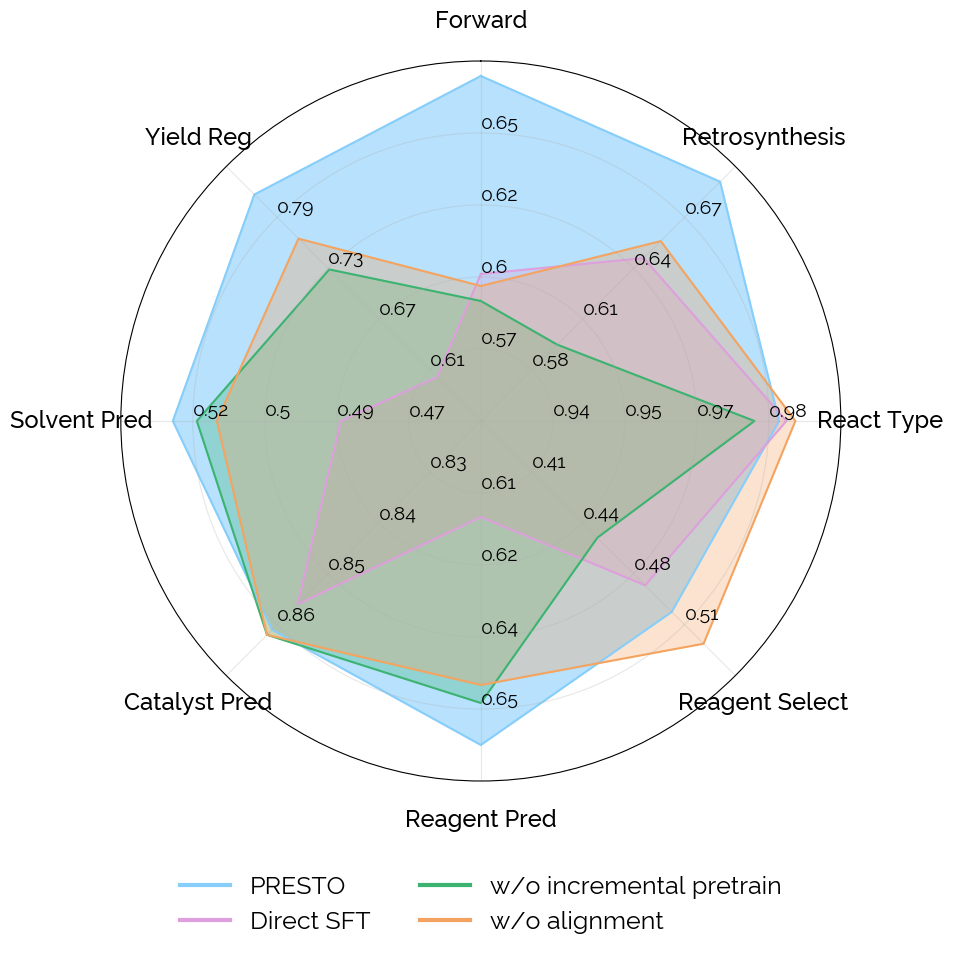

In [88]:
methods = ['PRESTO', 'Direct SFT', 'w/o incremental pretrain', 'w/o alignment']

data = {
  "Forward": [0.665, 0.599, 0.590, 0.595],  
  "Retrosynthesis": [0.691, 0.646, 0.595, 0.656],
  "React Type": [0.9863, 0.9879, 0.9808, 0.9899],
  "Reagent Select": [0.5000, 0.4833, 0.4533, 0.5200],
  "Reagent Pred": [0.654, 0.616, 0.647, 0.644],
  "Catalyst Pred": [0.861, 0.856, 0.862, 0.862], 
  "Solvent Pred": [0.527, 0.485, 0.521, 0.516],
  "Yield Reg": [0.8169, 0.6017, 0.7286, 0.7649]
}

ranges = [[0.55, 0.67], [0.55, 0.7], [0.92, 1.0], [0.38, 0.54], [0.6, 0.66], [0.82, 0.87], [0.45, 0.54], [0.55, 0.85]]
variables = list(data.keys())

format_cfg = {
    'rad_ln_args': {'visible':True, 'alpha':0.3},
    'angle_ln_args': {'visible':True, 'alpha':0.3},
    'rgrid_tick_lbls_args': {'fontsize':14},
    'theta_tick_lbls_pad': 18,
    'outer_ring':{'visible':True, 'color':'#000000'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':17, 'fontweight':550},
}

fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

custom_colors = ['#87CEFA', '#DDA0DD', '#3CB371', '#F4A460']
custom_alphas = [0.6, 0.3, 0.3, 0.3]

for i, method in enumerate(methods):
    radar.plot([d[i] for d in data.values()], label=method, color=custom_colors[i])
    radar.fill([d[i] for d in data.values()], alpha=custom_alphas[i], color=custom_colors[i])

radar.use_legend(**{'loc':'upper center', 'bbox_to_anchor':(0.5, -0.1), 'ncol':radar.plot_counter//2, 'fontsize':18, 'frameon':False})

# plt.title('Multi-stage Strategy Ablation', fontsize=24, fontweight='bold', pad=40)
plt.tight_layout()

plt.savefig('./multi_stage_performance_ablation_radar.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2189973/2196226297.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


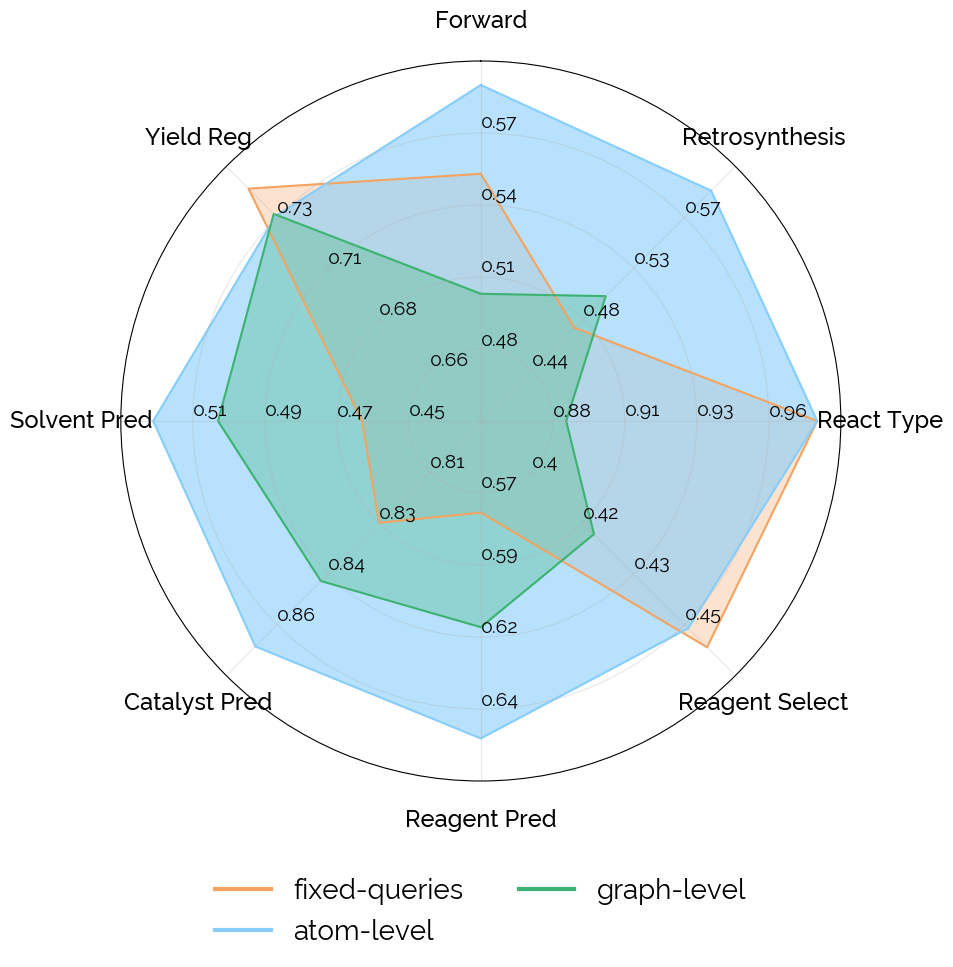

In [89]:
methods = ['fixed-queries', 'atom-level', 'graph-level']
data = {
  "Forward": [0.553, 0.590, 0.503],
  "Retrosynthesis": [0.477, 0.590, 0.503],
  "React Type": [0.9808, 0.9808, 0.8832],
  "Reagent Select": [0.4600, 0.4533, 0.4200],
  "Reagent Pred": [0.578, 0.647, 0.613],
  "Catalyst Pred": [0.828, 0.862, 0.844],
  "Solvent Pred": [0.463, 0.521, 0.503],
  "Yield Reg": [0.7404, 0.7286, 0.7295]
}
ranges = [[0.45, 0.60], [0.4, 0.61], [0.85, 0.99], [0.38, 0.47], [0.55, 0.66], [0.80, 0.87], [0.43, 0.53], [0.64, 0.75]]
variables = list(data.keys())

format_cfg = {
    'rad_ln_args': {'visible':True, 'alpha':0.3},
    'angle_ln_args': {'visible':True, 'alpha':0.3},
    'rgrid_tick_lbls_args': {'fontsize':14},
    'theta_tick_lbls_pad': 18,
    'outer_ring':{'visible':True, 'color':'#000000'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':17, 'fontweight':550},
}

fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

custom_colors = ['#F4A460', '#87CEFA', '#3CB371']
custom_alphas = [0.3, 0.6, 0.3]

for i, method in enumerate(methods):
    values = [d[i] for d in data.values()]
    radar.plot(values, label=method, color=custom_colors[i])
    radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])

radar.use_legend(**{'loc':'upper center', 'bbox_to_anchor':(0.5, -0.1), 'ncol':radar.plot_counter//2+1, 'fontsize':20, 'frameon':False})

# plt.title('Molecule Token Granularity Ablation', fontsize=24, fontweight='bold', pad=40)
plt.tight_layout()

plt.savefig('./token_resolution_ablation_radar.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2189973/2380216049.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


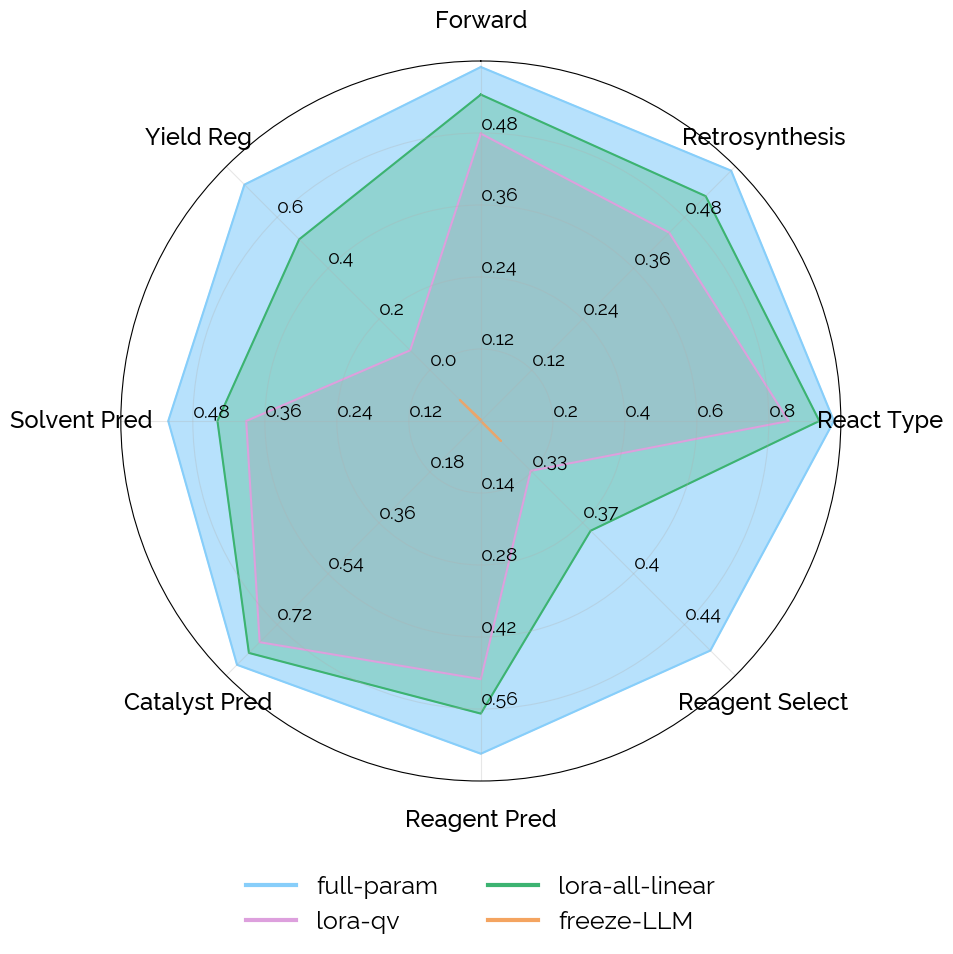

In [91]:
methods = ['full-param', 'lora-qv', 'lora-all-linear', 'freeze-LLM']
data = {
  "Forward": [0.590, 0.479, 0.544, 0.002],
  "Retrosynthesis": [0.590, 0.444, 0.530, 0.001],
  "React Type": [0.9808, 0.8550, 0.9403, 0.0000],
  "Reagent Select": [0.4533, 0.3333, 0.3733, 0.3133],
  "Reagent Pred": [0.647, 0.502, 0.569, 0.000],
  "Catalyst Pred": [0.862, 0.782, 0.820, 0.000],
  "Solvent Pred": [0.521, 0.391, 0.439, 0.000],
  "Yield Reg": [0.7286, 0.0776, 0.5136, -0.1172]
}
ranges = [[0.0, 0.6], [0.0, 0.6], [0.0, 1.0], [0.3, 0.47], [0.0, 0.7], [0.0, 0.9], [0.0, 0.6], [-0.2, 0.8]]

variables = list(data.keys())
format_cfg = {
    'rad_ln_args': {'visible':True, 'alpha':0.3},
    'angle_ln_args': {'visible':True, 'alpha':0.3},
    'rgrid_tick_lbls_args': {'fontsize':14},
    'theta_tick_lbls_pad': 18,
    'outer_ring':{'visible':True, 'color':'#000000'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':17, 'fontweight':550},
}

fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)
custom_colors = ['#87CEFA', '#DDA0DD', '#3CB371', '#F4A460']
custom_alphas = [0.6, 0.3, 0.3, 0.3]
for i, method in enumerate(methods):
    values = []
    for d in data.values():
        if d[i] == 'N/A':
            values.append(0.0)  
        else:
            values.append(d[i])
    radar.plot(values, label=method, color=custom_colors[i])
    radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])
radar.use_legend(**{'loc':'upper center', 'bbox_to_anchor':(0.5, -0.1), 'ncol':radar.plot_counter//2, 'fontsize':18, 'frameon':False})
# plt.title('# Trainable Param Ablation', fontsize=24, fontweight='bold', pad=40)  
plt.tight_layout()
plt.savefig('./sft_llm_param_ablation_radar.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2189973/2394081949.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


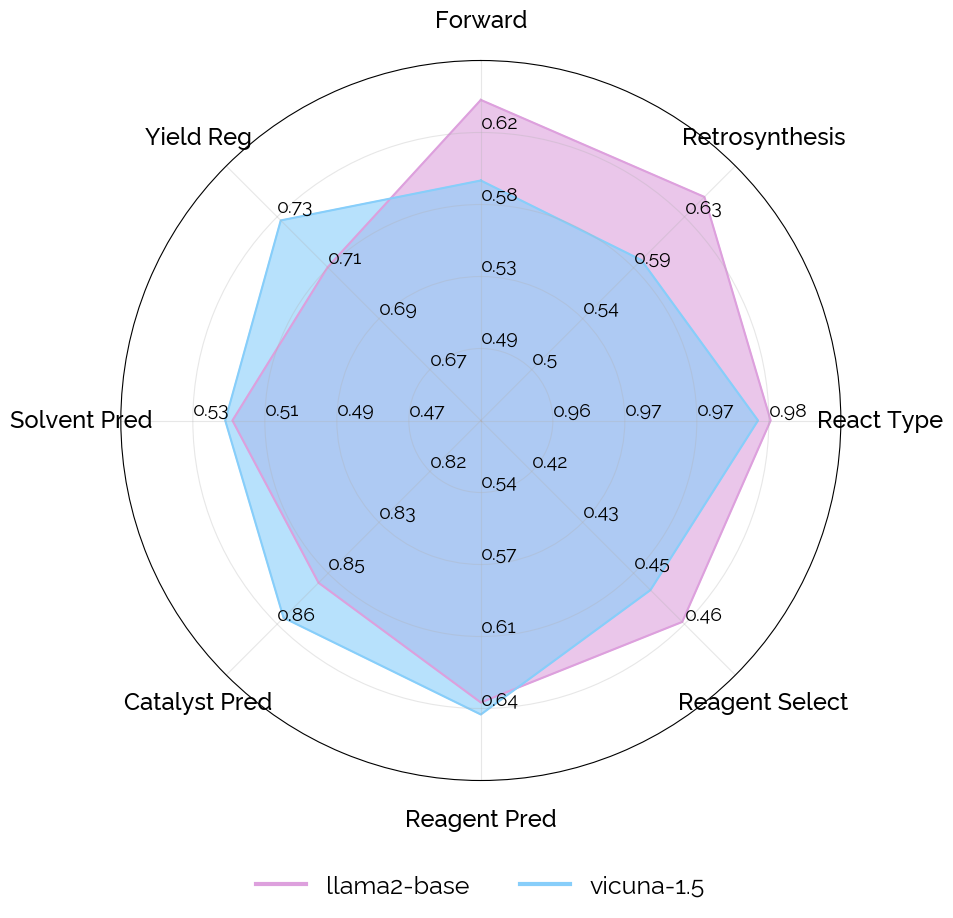

In [92]:
methods = ['llama2-base', 'vicuna-1.5']
data = {
  "Forward": [0.637, 0.590],
  "Retrosynthesis": [0.652, 0.595],
  "React Type": [0.9822, 0.9808],
  "Reagent Select": [0.4633, 0.4533],
  "Reagent Pred": [0.641, 0.647],
  "Catalyst Pred": [0.851, 0.862],
  "Solvent Pred": [0.519, 0.521],
  "Yield Reg": [0.7102, 0.7286]
}
ranges = [[0.45, 0.66], [0.45, 0.68], [0.95, 0.99], [0.40, 0.48], [0.5, 0.68], [0.8, 0.88], [0.45, 0.55], [0.65, 0.75]]

variables = list(data.keys())
format_cfg = {
    'rad_ln_args': {'visible':True, 'alpha':0.3},
    'angle_ln_args': {'visible':True, 'alpha':0.3},
    'rgrid_tick_lbls_args': {'fontsize':14},
    'theta_tick_lbls_pad': 18,
    'outer_ring':{'visible':True, 'color':'#000000'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':17, 'fontweight':550},
}
fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)
custom_colors = ['#DDA0DD', '#87CEFA']
custom_alphas = [0.6, 0.6]  
for i, method in enumerate(methods):
    values = [d[i] for d in data.values()]
    radar.plot(values, label=method, color=custom_colors[i]) 
    radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])
radar.use_legend(**{'loc':'upper center', 'bbox_to_anchor':(0.5, -0.1), 'ncol':radar.plot_counter, 'fontsize':18, 'frameon':False})
# plt.title('Base vs. Instruct-Tuned LMs', fontsize=24, fontweight='bold', pad=40)
plt.tight_layout()
plt.savefig('./base_vs_instruct_tuned_lms_radar.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2189973/3938495795.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


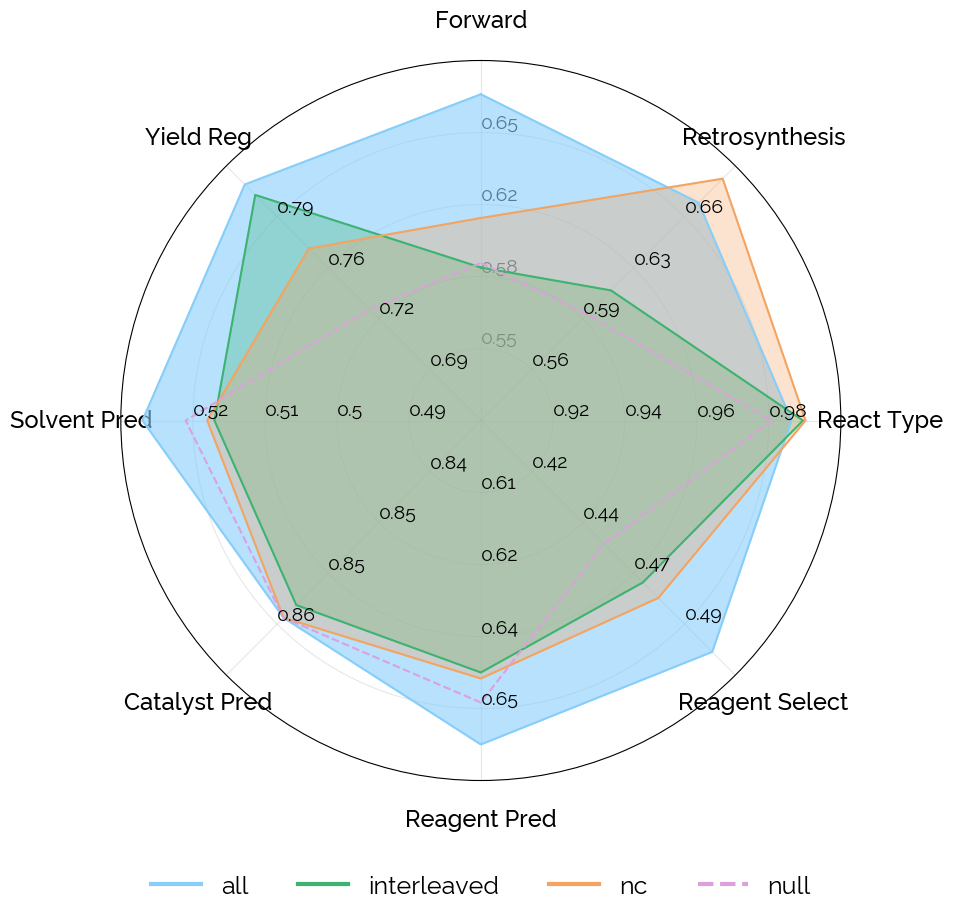

In [94]:
methods = ['all', 'interleaved', 'nc', 'null']
data = {
  "Forward": [0.665, 0.588, 0.610, 0.590],
  "Retrosynthesis": [0.674, 0.612, 0.691,  0.595],
  "React Type": [0.9863, 0.9895, 0.9902, 0.9808],
  "Reagent Select": [0.5000, 0.4700, 0.4767, 0.4533],
  "Reagent Pred": [0.654, 0.642, 0.643, 0.647],
  "Catalyst Pred": [0.861, 0.859, 0.861, 0.861],
  "Solvent Pred": [0.527, 0.517, 0.518, 0.521],
  "Yield Reg": [0.8169, 0.8095, 0.7716, 0.7286]
}
ranges = [[0.52, 0.68], [0.52, 0.70], [0.9, 1.0], [0.4, 0.51], [0.60, 0.66], [0.83, 0.87], [0.48, 0.53], [0.65, 0.83]]

variables = list(data.keys())
format_cfg = {
    'rad_ln_args': {'visible':True, 'alpha':0.3},
    'angle_ln_args': {'visible':True, 'alpha':0.3},
    'rgrid_tick_lbls_args': {'fontsize':14},
    'theta_tick_lbls_pad': 18,
    'outer_ring':{'visible':True, 'color':'#000000'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':17, 'fontweight':550},
}

fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

custom_colors = ['#87CEFA', '#3CB371', '#F4A460', '#DDA0DD']
custom_alphas = [0.6, 0.3, 0.3, 0.2]

for i, method in enumerate(methods):  
    values = []
    if i==3:
        radar.plot(values, label=method, color=custom_colors[i], linestyle='--')
        # radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])
    else:
        radar.plot(values, label=method, color=custom_colors[i])
        radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])
radar.use_legend(**{'loc':'upper center', 'bbox_to_anchor':(0.5, -0.1), 'ncol':radar.plot_counter, 'fontsize':18, 'frameon':False})
# plt.title('Pretrain Stage2 Dataset Composition', fontsize=24, fontweight='bold', pad=40)
plt.tight_layout()  
plt.savefig('./stage2_pretrain_dataset_composition_radar.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2189973/3557913423.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipykernel_2189973/3557913423.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


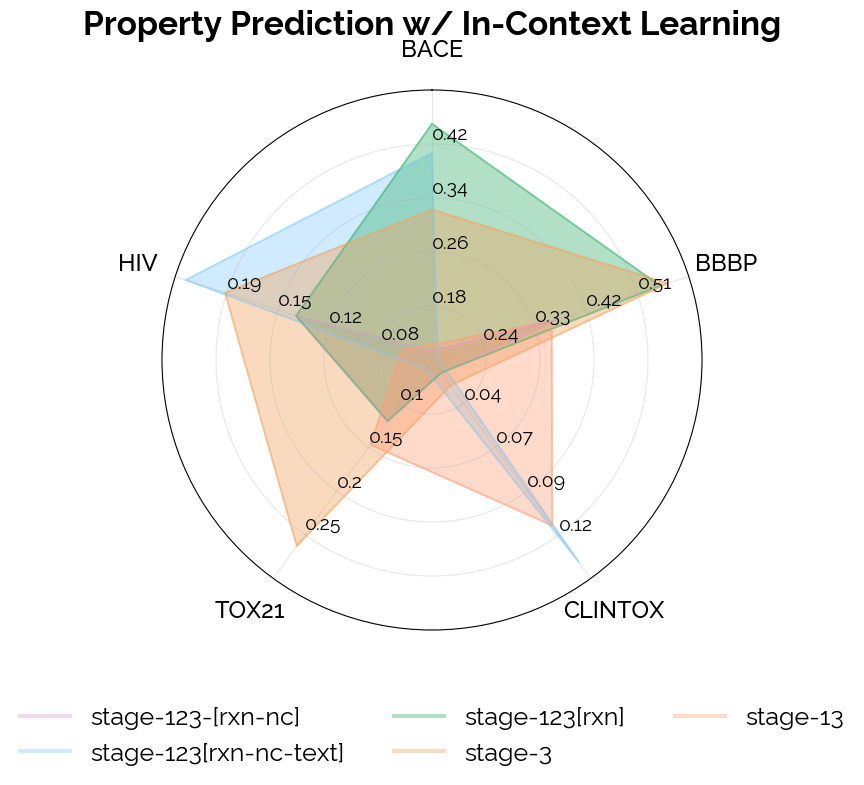

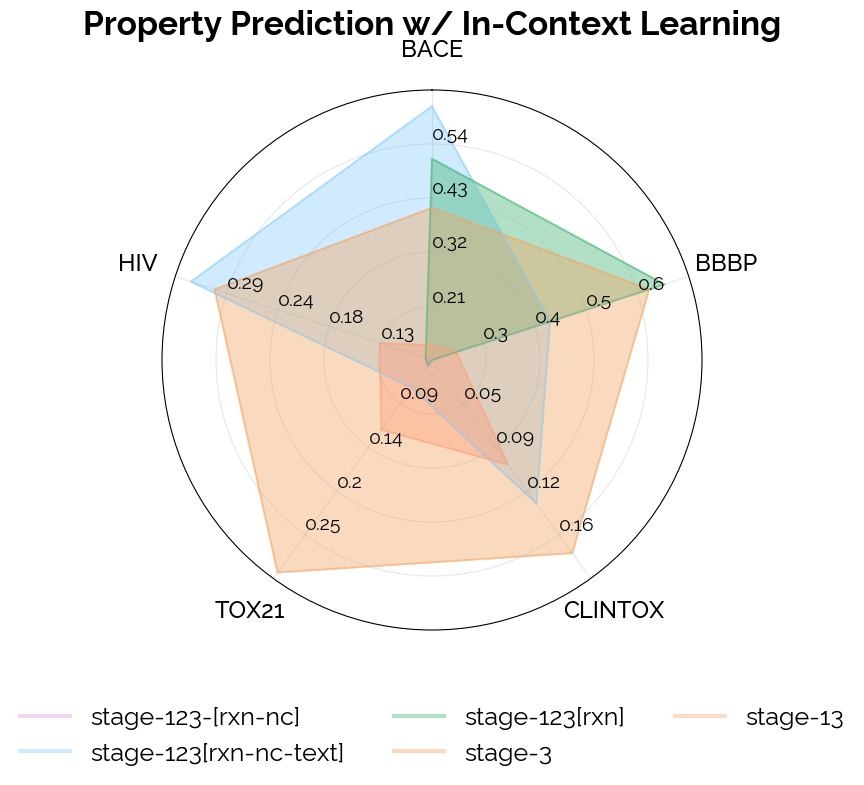

In [95]:
tasks = ['bace', 'bbbp', 'clintox', 'tox21', 'hiv']

methods = ['stage-123-[rxn-nc]', 'stage-123[rxn-nc-text]', 'stage-123[rxn]', 'stage-3', 'stage-13']

format_cfg = {
    'rad_ln_args': {'visible':True, 'alpha':0.3},
    'angle_ln_args': {'visible':True, 'alpha':0.3},
    'rgrid_tick_lbls_args': {'fontsize':14},
    'theta_tick_lbls_pad': 18,
    'outer_ring':{'visible':True, 'color':'#000000'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':17, 'fontweight':550},
}


custom_colors = ['#DDA0DD', '#87CEFA', '#3CB371', '#F4A460', '#FFA07A']
custom_alphas = [0.4, 0.4, 0.4, 0.4, 0.4]

data_4_shot = {
    'bace': [0.113, 0.407, 0.450, 0.323, 0.123],
    'bbbp': [0.373, 0.160, 0.550, 0.563, 0.360],
    'clintox': [0.027, 0.131, 0.027, 0.034, 0.111],
    'tox21': [0.120, 0.060, 0.120, 0.263, 0.147],
    'hiv': [0.140, 0.213, 0.140, 0.187, 0.070]
}

data_8_shot = {
    'bace': [0.100, 0.617, 0.510, 0.410, 0.130],
    'bbbp': [0.213, 0.430, 0.653, 0.623, 0.247],
    'clintox': [0.010, 0.135, 0.010, 0.178, 0.101],
    'tox21': [0.047, 0.073, 0.047, 0.293, 0.123],
    'hiv': [0.077, 0.333, 0.077, 0.307, 0.127]
}

ranges_4_shot = [[0.1, 0.5], [0.15, 0.6], [0.02, 0.14], [0.05, 0.3], [0.05, 0.22]]
ranges_8_shot = [[0.1, 0.65], [0.2, 0.7], [0.01, 0.2], [0.04, 0.3], [0.07, 0.35]]

variables = [task.upper() for task in tasks]

for shot, data, ranges in [('4-shot', data_4_shot, ranges_4_shot), ('8-shot', data_8_shot, ranges_8_shot)]:
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

    for i, method in enumerate(methods):
        values = [data[task][i] for task in tasks]
        radar.plot(values, label=method, color=custom_colors[i], alpha=custom_alphas[0])
        radar.fill(values, color=custom_colors[i], alpha=custom_alphas[0])

    radar.use_legend(**{'loc':'upper center', 'bbox_to_anchor':(0.5, -0.1), 'ncol':3, 'fontsize':18, 'frameon':False})

    plt.title('Property Prediction w/ In-Context Learning', fontsize=24, fontweight='bold', pad=40)
    plt.tight_layout()

    plt.savefig(f'./model_accuracy_{shot}_radar.pdf', dpi=300, bbox_inches='tight')

# scaling training time

/tmp/ipykernel_2189973/4216569101.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


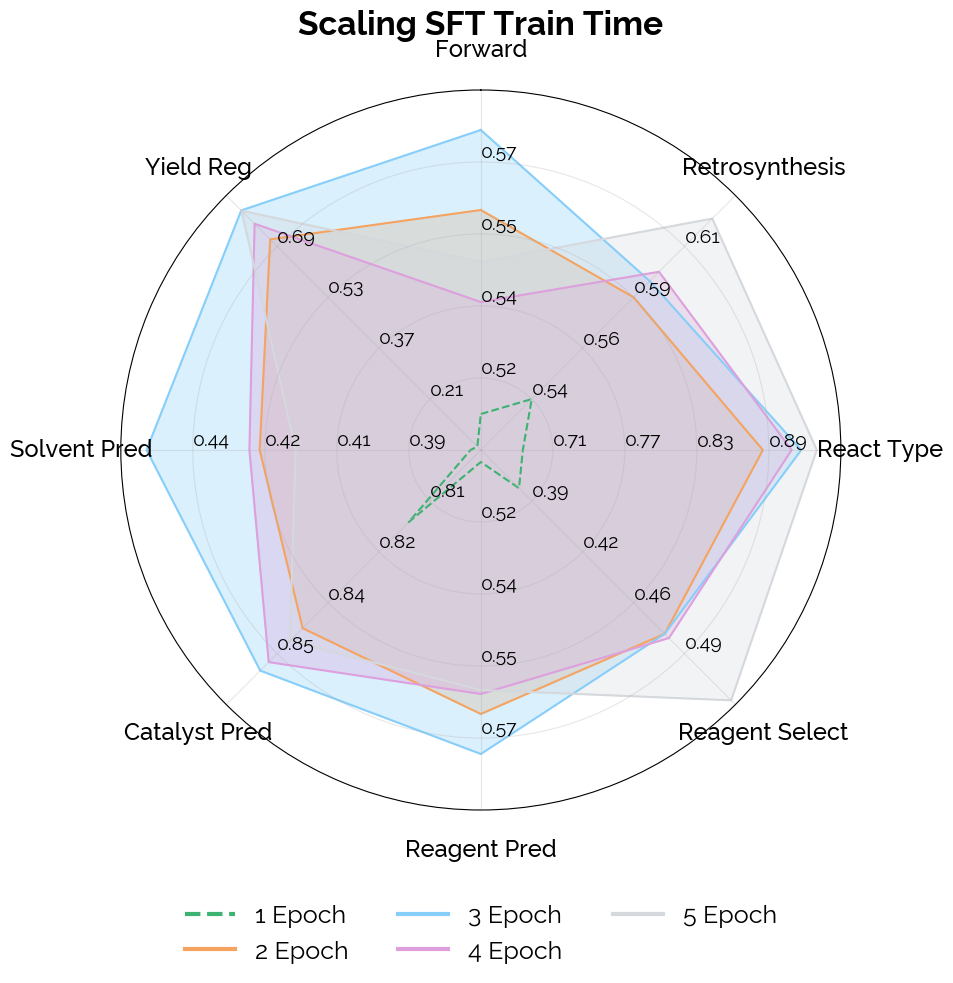

In [96]:
methods = ['1 Epoch', '2 Epoch', '3 Epoch', '4 Epoch', '5 Epoch']
data = {
  "Forward": [0.509, 0.560, 0.580, 0.537, 0.547],
  "Retrosynthesis": [0.542, 0.586, 0.593,  0.597, 0.62],
  "React Type": [0.685, 0.885, 0.917, 0.909, 0.930],
  "Reagent Select": [0.377, 0.480, 0.480, 0.483, 0.527],
  "Reagent Pred": [0.503, 0.566, 0.576, 0.561, 0.560],
  "Catalyst Pred": [0.817, 0.842, 0.852, 0.850, 0.845],
  "Solvent Pred": [0.382, 0.423, 0.445, 0.425, 0.416],
  "Yield Reg": [0.061, 0.712, 0.803, 0.761, 0.802]
}
ranges = [[0.50, 0.59], [0.52, 0.63], [0.65, 0.95], [0.35, 0.53], [0.50, 0.59], [0.80, 0.86], [0.38, 0.45], [0.05, 0.85]]

variables = list(data.keys())
format_cfg = {
    'rad_ln_args': {'visible':True, 'alpha':0.3},
    'angle_ln_args': {'visible':True, 'alpha':0.3},
    'rgrid_tick_lbls_args': {'fontsize':14},
    'theta_tick_lbls_pad': 18,
    'outer_ring':{'visible':True, 'color':'#000000'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':17, 'fontweight':550},
}

fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

custom_colors = ['#3CB371', '#F4A460', '#87CEFA', '#DDA0DD', '#D5D8DC']
custom_alphas = [0.3, 0.3, 0.3, 0.3, 0.3]
line_styles = ['--', '-', '-', '-', '-']
fill_needs = [False, True, True, True, True]

for i, method in enumerate(methods):  
    values = []
    for j, d in enumerate(data.values()):
        if d[i] == 'N/A':
            values.append(np.mean(ranges[j]))
        else:
            values.append(d[i])
    radar.plot(values, label=method, color=custom_colors[i], linestyle=line_styles[i])
    if fill_needs[i]:
        radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])
    # radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])
radar.use_legend(**{'loc':'upper center', 'bbox_to_anchor':(0.5, -0.1), 'ncol':radar.plot_counter//2+1, 'fontsize':18, 'frameon':False})
# plt.title('Scaling SFT Train Time', fontsize=24, fontweight='bold', pad=40)
plt.tight_layout()  
plt.savefig('./scaling_sft_train_time.pdf', dpi=300, bbox_inches='tight')

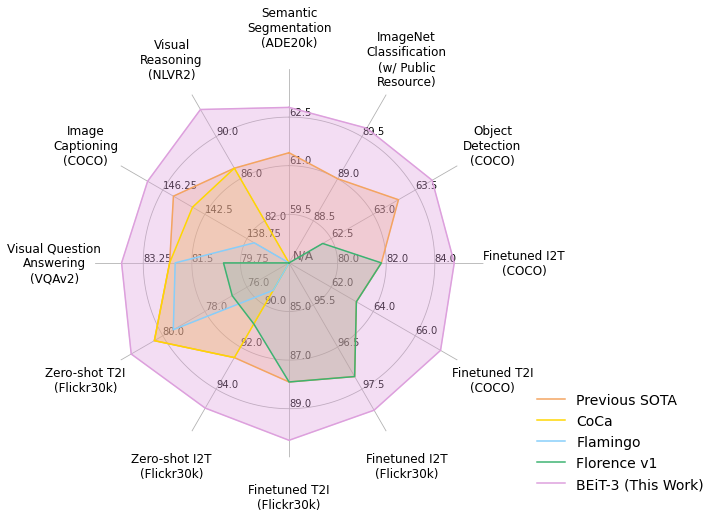

In [ ]:
ranges = list(data_min_max.values())
variables = data.keys()

format_cfg = {
    'rad_ln_args': {'visible':True},
    'angle_ln_args':{'visible':True},
    'rgrid_tick_lbls_args': {'fontsize':10},
    'theta_tick_lbls_pad': 30,
    'outer_ring':{'visible':False, 'color':'#d6d6d6'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':12},
}


fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=4, show_scales=True, format_cfg=format_cfg)

# custom_colors = ['#DDA0DD', '#F5C6D1', '#FAF7B6', '#C2F2FF', '#3CB371']
custom_colors = ['#DDA0DD', '#FFD700', '#87CEFA', '#3CB371', '#F4A460']
custom_alphas = [0.35, 0.2, 0.2, 0.2, 0.3]

for g in [4, 1, 2, 3, 0]:
  radar.plot([i[g] for i in list(data.values())], label=f"{methods[g]}", color=custom_colors[g])
  radar.fill([i[g] for i in list(data.values())], alpha=custom_alphas[g], color=custom_colors[g])

# radar.set_title("Radar chart solution with different scales", pad=25)
radar.use_legend(**{'loc':'lower right', 'bbox_to_anchor':(1.6, -0.12), 'ncol':radar.plot_counter, 'fontsize':14, 'ncol':1, 'frameon':False})

plt.text(0.56, 0.56, 'N/A', transform=plt.gcf().transFigure, fontsize=12)

# plt.show() 
plt.savefig('./radar_compare.pdf', dpi=500, bbox_inches='tight')